In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

!pip install optuna
!pip install timm
!pip install scikit-learn
!pip install pandas
!pip install seaborn

torch version: 1.13.1
torchvision version: 0.14.1


In [2]:
# Continue with regular imports
!pip install matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
!pip install ipython-autotime
%load_ext autotime

time: 397 µs (started: 2023-05-04 13:05:05 +00:00)


In [ ]:
#unzip the data that we had split earlier before in the preprocessing notebook, to ensure that the same arrangement of data 
#is used for every model. 
!unzip /isic2019-dataset.zip

In [3]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Get a set of pretrained model weights
weights = torchvision.models.MaxVit_T_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

# define the transform function that will be used in imagefolder to preprocess the data for MaxViT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[224]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

time: 5.73 ms (started: 2023-05-04 13:05:05 +00:00)


In [4]:
# loading and transforming the data

!pip install torchsampler
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import Subset
from torchsampler import ImbalancedDatasetSampler

# Set the random seed for reproducibility
torch.manual_seed(42)

# Load and transform the data
train_dataset = datasets.ImageFolder(root='data/train', transform=auto_transforms)
test_dataset = datasets.ImageFolder(root='data/test', transform=auto_transforms)
val_dataset = datasets.ImageFolder(root='data/valid', transform=auto_transforms)

# load the data and shuffle the training data
train_dataloader = data.DataLoader(train_dataset, batch_size=32, sampler=ImbalancedDatasetSampler(train_dataset),pin_memory=True, num_workers=4)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
valid_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False,pin_memory=True, num_workers=4)

time: 3.43 s (started: 2023-05-04 13:05:05 +00:00)


In [5]:
import timm 
#look up all the maxvit models in timm's library
maxvit_models = timm.list_models('*maxvit*')
maxvit_models

['maxvit_base_224',
 'maxvit_large_224',
 'maxvit_nano_rw_256',
 'maxvit_pico_rw_256',
 'maxvit_rmlp_nano_rw_256',
 'maxvit_rmlp_pico_rw_256',
 'maxvit_rmlp_small_rw_224',
 'maxvit_rmlp_small_rw_256',
 'maxvit_rmlp_tiny_rw_256',
 'maxvit_small_224',
 'maxvit_tiny_224',
 'maxvit_tiny_pm_256',
 'maxvit_tiny_rw_224',
 'maxvit_tiny_rw_256',
 'maxvit_xlarge_224']

time: 187 ms (started: 2023-05-04 13:05:08 +00:00)


In [ ]:
#create the maxvit model
#to create this code, timm's library has been used. 
#create model with new variable name and the best HP values to re-train the model 

import timm 
import torch
import torch.nn as nn

# Set the random seed for reproducibility
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
new_model = timm.create_model('maxvit_rmlp_small_rw_224', pretrained=True, num_classes=8)

num_in_features = new_model.get_classifier().in_features

# Define the classification head
num_hidden_layers = 2
num_neurons = 256
dropout = 0.25
classifier_layers = []
for i in range(num_hidden_layers):
    if i == 0:
        in_features = num_in_features
        out_features = num_neurons
    else:
        in_features = num_neurons
        out_features = num_neurons
    classifier_layers.extend([
        nn.Linear(in_features, out_features),
        nn.BatchNorm1d(out_features),
        nn.Dropout(p=dropout),
    ])
classifier_layers.append(nn.Linear(num_neurons, 8))
new_model.head.fc = nn.Sequential(*classifier_layers)

#freeze the weights
for param in new_model.parameters():
    param.requires_grad = False
   
# unfreeze the last fc layer
for param in new_model.head.parameters():
    param.requires_grad = True


new_model.to(device)

In [7]:
# Print a summary using torchinfo (uncomment for actual output)

summary(model=new_model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MaxxVit (MaxxVit)                                                 [32, 3, 224, 224]    [32, 8]              --                   Partial
├─Stem (stem)                                                     [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    └─Conv2d (conv1)                                             [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNormAct2d (norm1)                                     [32, 32, 112, 112]   [32, 32, 112, 112]   64                   False
│    │    └─Identity (drop)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    │    └─SiLU (act)                                            [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Conv2d (conv2)                                  

time: 1.85 s (started: 2023-05-04 13:05:10 +00:00)


In [8]:
# define optimizers and loss function and use the best hyperparameters found during the HP tuning
import torch.optim as optim

# Set the random seed for reproducibility
torch.manual_seed(42)

# define optimizers and loss function. 
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(new_model.parameters(), lr=0.0010922617771103266, weight_decay = 0.009180866149599651)

time: 2.67 ms (started: 2023-05-04 13:05:12 +00:00)


In [9]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

# Lists to store the loss and accuracy values
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Initialize variables for early stopping
best_val_loss = float('inf')
patience = 5
no_improvement_count = 0
epochs= 20
num_epochs = 20

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    running_total = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()    # Scale the gradients
            scaler.step(optimizer)           # Update the model parameters
            scaler.update()                  # Update the scaler

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        running_total += labels.size(0)
        running_corrects += (predicted == labels).sum().item()

    # Calculate the training loss and training accuracy
    train_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = 100 * running_corrects / running_total

    # evaluate on the validation set
    correct = 0
    total = 0
    val_loss = 0.0
    new_model.eval()
    with torch.no_grad():
        for data in valid_dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = new_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item() * labels.size(0)

    # Calculate the validation accuracy and validation loss
    val_accuracy = 100 * correct / total
    val_loss /= len(valid_dataloader.dataset)

        
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
            
    # Save the loss and accuracy values
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    # Check if the current validation loss is the best seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = new_model.state_dict()
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    # Stop training if the validation loss has not improved for `patience` epochs
    if epochs_since_improvement == patience:
        print(f"No improvement for {patience} epochs, stopping training.")
        break

Epoch 1/20: Train Loss: 1.2837, Train Acc: 53.9571, Val Loss: 1.2085, Val Acc: 56.6379
Epoch 2/20: Train Loss: 0.9323, Train Acc: 66.7773, Val Loss: 1.1336, Val Acc: 61.1548
Epoch 3/20: Train Loss: 0.8853, Train Acc: 67.8825, Val Loss: 1.1391, Val Acc: 59.5444
Epoch 4/20: Train Loss: 0.8429, Train Acc: 69.5624, Val Loss: 1.2355, Val Acc: 56.6771
Epoch 5/20: Train Loss: 0.8081, Train Acc: 70.8955, Val Loss: 1.0842, Val Acc: 61.1940
Epoch 6/20: Train Loss: 0.7997, Train Acc: 71.7627, Val Loss: 1.2260, Val Acc: 58.0518
Epoch 7/20: Train Loss: 0.7852, Train Acc: 71.2969, Val Loss: 1.1683, Val Acc: 60.7227
Epoch 8/20: Train Loss: 0.7636, Train Acc: 72.6349, Val Loss: 1.2011, Val Acc: 59.9764
Epoch 9/20: Train Loss: 0.7541, Train Acc: 72.7340, Val Loss: 1.1824, Val Acc: 59.4658
Epoch 10/20: Train Loss: 0.7312, Train Acc: 73.7499, Val Loss: 1.1546, Val Acc: 61.4690
No improvement for 5 epochs, stopping training.
time: 18min 37s (started: 2023-05-04 13:05:12 +00:00)


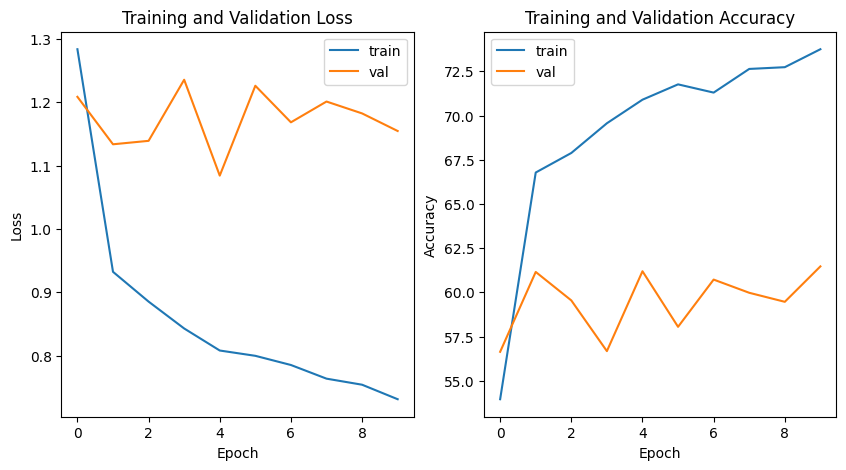

time: 258 ms (started: 2023-05-04 13:23:50 +00:00)


In [11]:
# Plot the validation and training loss and accuracy values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(val_losses, label='val')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(val_accs, label='val')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()
plt.show()

In [12]:
#evaluate on test set and calculate metrics

from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
import pandas as pd
import numpy as np

new_model.eval()
test_loss = 0.0
test_acc = 0.0
y_true = []
y_scores = []
y_pred = []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
        outputs = new_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        test_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

        # Append predictions to lists
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

test_loss /= len(test_dataloader.dataset)
test_acc /= len(test_dataloader.dataset)

# Calculate metrics

import warnings
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(8)], digits=4)

conf_mat = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(np.array(pd.get_dummies(y_true)), y_scores, average='macro')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate other metrices
n_classes = conf_mat.shape[0]
sensitivity = 0
specificity = 0
for i in range(n_classes):
    tp = conf_mat[i,i]
    fn = np.sum(conf_mat[i,:]) - tp
    fp = np.sum(conf_mat[:,i]) - tp
    tn = np.sum(conf_mat) - tp - fn - fp
    sensitivity += tp / (tp + fn) * np.sum(conf_mat[i,:])
    specificity += tn / (tn + fp) * np.sum(conf_mat[i,:])
sensitivity /= np.sum(conf_mat)
specificity /= np.sum(conf_mat)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Loss: 1.1558
Test Accuracy: 0.6048
Sensitivity: 0.6048
Specificity: 0.8976
ROC-AUC: 0.8518
F1-score: 0.6257
Classification Report:
              precision    recall  f1-score   support

           0     0.2378    0.4382    0.3083        89
           1     0.5767    0.5563    0.5663       311
           2     0.3729    0.3986    0.3853       276
           3     0.1127    0.2963    0.1633        27
           4     0.5011    0.5111    0.5061       450
           5     0.8585    0.7153    0.7804      1349
           6     0.2561    0.5122    0.3415        82
           7     0.3103    0.4091    0.3529        22

    accuracy                         0.6048      2606
   macro avg     0.4033    0.4796    0.4255      2606
weighted avg     0.6592    0.6048    0.6257      2606

time: 56.9 s (started: 2023-05-04 13:23:50 +00:00)


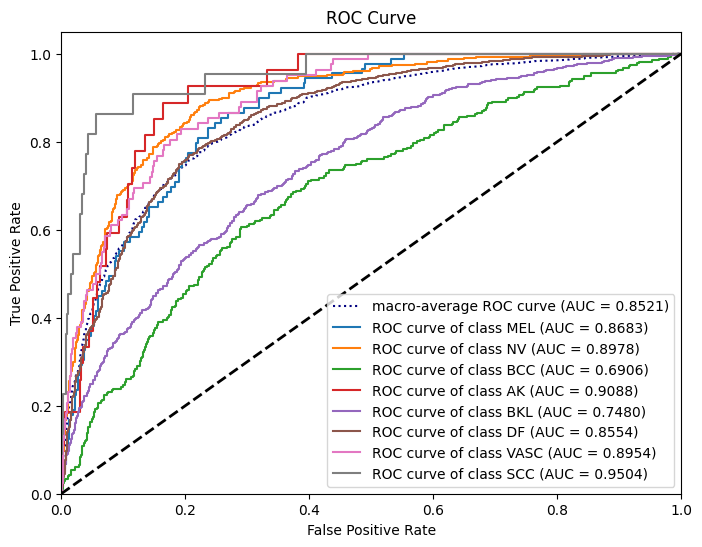

time: 192 ms (started: 2023-05-04 13:24:47 +00:00)


In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Convert the y_true and y_scores lists to arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_true))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (AUC = {0:0.4f})'.format(roc_auc["macro"]), color='navy', linestyle=':')

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.4f})'.format(class_dict[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

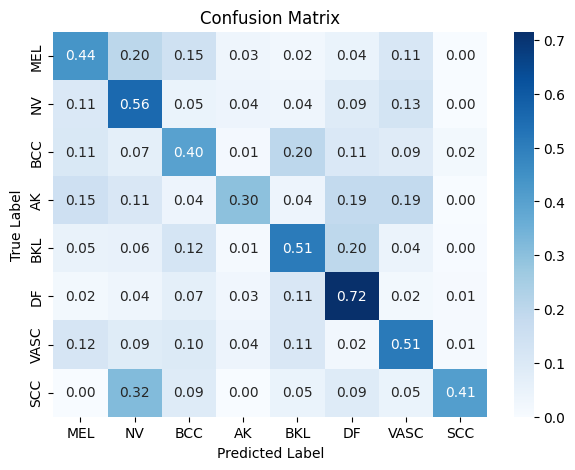

time: 269 ms (started: 2023-05-04 13:24:47 +00:00)


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
class_labels = sorted(list(class_dict.keys()), key=lambda x: int(x))
ax.xaxis.set_ticklabels([class_dict[label] for label in class_labels])
ax.yaxis.set_ticklabels([class_dict[label] for label in class_labels])
plt.show()